In [7]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

In [9]:
df = pd.read_csv('data/output.csv')

# Proprocessing

In [10]:
# download nltk data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.downloader.download('maxent_ne_chunker')
nltk.downloader.download('words')
nltk.downloader.download('treebank')
nltk.downloader.download('maxent_treebank_pos_tagger')


[nltk_data] Downloading package punkt to /Users/zmao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/zmao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/zmao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zmao/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [95]:
import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")
doc = nlp("Thyroid-associated orbitopathy (TO) is an autoimmune-mediated orbital inflammation that can lead to disfigurement and blindness. Multiple genetic loci have been associated with Graves' disease, but the genetic basis for TO is largely unknown. This study aimed to identify loci associated with TO in individuals with Graves' disease, using a genome-wide association scan (GWAS) for the first time to our knowledge in TO.Genome-wide association scan was performed on pooled DNA from an Australian Caucasian discovery cohort of 265 participants with Graves' disease and TO (cases) and 147 patients with Graves disease without TO (controls).")

# document level
ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]
print(ents)

Defaulting to user installation because normal site-packages is not writeable
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


[('Graves', 177, 183, 'ORG'), ('Graves', 316, 322, 'ORG'), ('first', 385, 390, 'ORDINAL'), ('Australian', 484, 494, 'NORP'), ('Caucasian', 495, 504, 'NORP'), ('265', 525, 528, 'CARDINAL'), ('Graves', 547, 553, 'PERSON'), ('147', 582, 585, 'CARDINAL')]


In [94]:
import en_core_web_sm
nlp = en_core_web_sm.load()

ModuleNotFoundError: No module named 'en_core_web_sm'

In [92]:
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 16.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [108]:
from krovetzstemmer import Stemmer
import pycountry
lemmatizer = WordNetLemmatizer()
stemmer = Stemmer() 

def is_adjective(word):
    pos = nltk.pos_tag([word])[0][1]
    return pos in ['JJ', 'JJR', 'JJS']

# text data cleaning
def clean_text_lem(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(word) for word in text if word not in stopwords.words('english')]
    lemmatized = ' '.join(lemmatized)

    return lemmatized

def clean_text_stem(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = word_tokenize(text)
    stemmed = [stemmer.stem(word) for word in text if word not in stopwords.words('english')]
    stemmed = ' '.join(stemmed)
    return stemmed

def clean_text_adj(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = word_tokenize(text)
    stemmed = [word for word in text if is_adjective(word) or word == 'terrorism' ]
    stemmed = ' '.join(stemmed)
    return stemmed

# Get a list of all country names
countries = [country.name.lower() for country in pycountry.countries]
def get_countries(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    doc = nlp(text)
    ents = [e.text for e in doc.ents if e.label_ in ['NORP', 'GPE']]

    return ents


df['cleaned_text_lem'] = df['full text'].apply(clean_text_lem)
df['cleaned_text_stem'] = df['full text'].apply(clean_text_stem)
df['cleaned_text_adj'] = df['full text'].apply(clean_text_adj)
df['countries'] = df['full text'].apply(get_countries)
df['countries'] = df['countries'].apply(lambda x: list(set([stemmer.stem(country) for country in x])))

In [136]:
df.to_csv('data/output.csv', index=False)

# Places

In [ ]:
def get_places_stat(df, label):
    places = df['countries'].tolist()
    places = [place for sublist in places for place in sublist]
    # replace 'the united states' 'america' 'us' with 'united states'
    places = [place if place not in ['the united states', 'america', 'us'] else 'united states' for place in places]
    places = pd.Series(places)
    places = places.value_counts().reset_index()
    places.columns = ['place', 'count']
    places['count_normalized'] = places['count'] / places['count'].sum()
    places['label'] = label
    return places

In [ ]:
date_range = [[1980, 1985], [1986, 1990], [1991, 1995], [1996, 2000], [2001, 2005], [2006, 2010], [2011, 2015], [2016, 2020]]

In [ ]:
# get the places for each date range
for date in date_range:
    df_date = df.loc[(df['year'] >= date[0]) & (df['year'] <= date[1])]
    places = get_places_stat(df_date, f'{date[0]} - {date[1]}')
    places.to_csv(f'output/places/places_{date[0]}_{date[1]}.csv', index=False)
    
# combine the results
df_output_places = pd.concat([pd.read_csv(f'output/places/places_{date[0]}_{date[1]}.csv') for date in date_range])
df_output_places.to_csv('output/places/places_by_years.csv', index=False)

In [ ]:
df_output_places

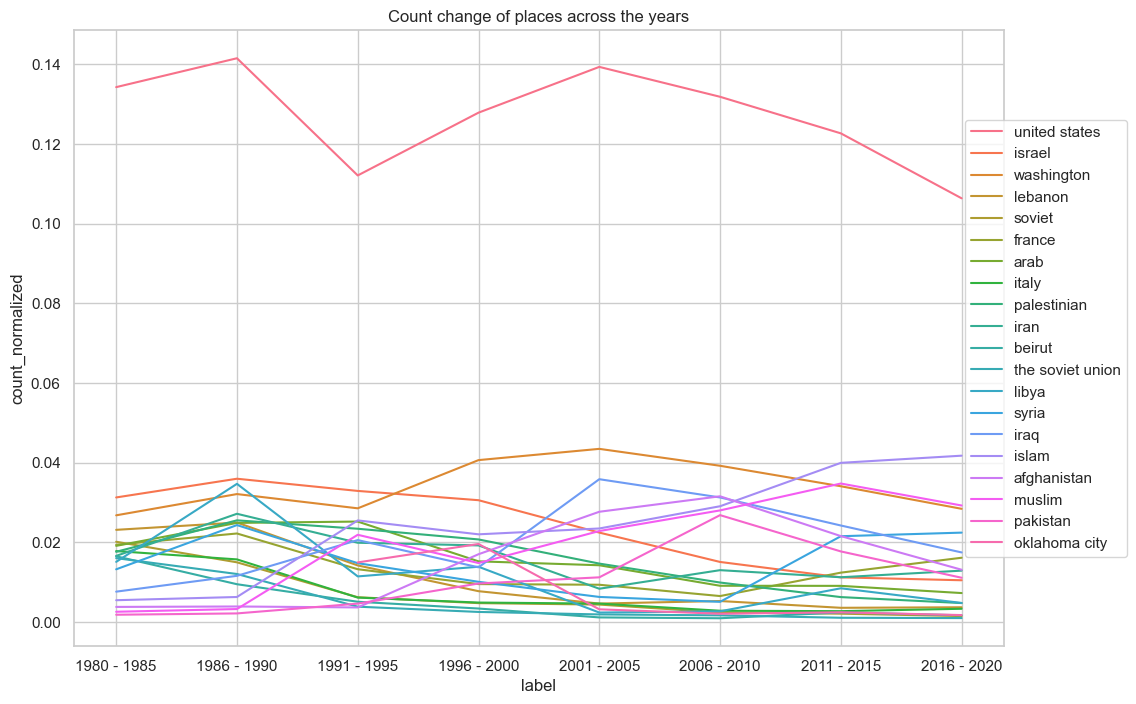

In [253]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_output_places_filtered = df_output_places.groupby('place').filter(lambda x:  np.std(x.count_normalized)  >= 0.005)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_output_places_filtered, x='label', y='count_normalized', hue='place')
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5), ncol=1)
plt.title('Count change of places across the years')
plt.savefig('output/places/places_by_years.png')
plt.show()

# Colocates

In [138]:
from nltk.collocations import *
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess

def get_colocates(df, label):
    data = df.values.tolist()
    
    data_words = [[word for word in simple_preprocess(str(doc))] for doc in data]
    tokens = [i for j in data_words for i in j]
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    
    word = 'terrorism'
    df_output_col = pd.DataFrame(columns=['rank', 'word_of_interest', 'colocate', 'score', 'score_normalized', 'label'])
    word_filter = lambda *w: word not in w
    
    finder = BigramCollocationFinder.from_words(tokens)
    finder.apply_freq_filter(3)
    finder.apply_ngram_filter(word_filter)
    counter = 0 
    for i in finder.score_ngrams(bigram_measures.likelihood_ratio):
        df_output_col.loc[len(df_output_col.index)] = [counter, word, i[0], i[1], i[1] / finder.N, label] 
        counter += 1  
    return df_output_col

In [270]:
# get the colocates for each date range
for date in date_range:
    df_date = df.loc[(df['year'] >= date[0]) & (df['year'] <= date[1])]
    res = get_colocates(df_date['cleaned_text_stem'], f'{date[0]} - {date[1]}')
    res.to_csv(f'output/colocates/colocates_{date[0]}_{date[1]}.csv', index=False)
    
# combine the results
df_output = pd.concat([pd.read_csv(f'output/colocates/colocates_{date[0]}_{date[1]}.csv') for date in date_range])
df_output.to_csv('output/colocates/colocates_by_years_stem.csv', index=False)

In [271]:
df_output

,rank,word_of_interest,colocate,score,score_normalized,label
0,0,terrorism,"('international', 'terrorism')",1715.605789,3.964216e-03,1980 - 1985
1,1,terrorism,"('combat', 'terrorism')",837.284743,1.934697e-03,1980 - 1985
2,2,terrorism,"('fight', 'terrorism')",490.958525,1.134448e-03,1980 - 1985
3,3,terrorism,"('acts', 'terrorism')",468.889557,1.083454e-03,1980 - 1985
4,4,terrorism,"('sponsor', 'terrorism')",360.267285,8.324625e-04,1980 - 1985
...,...,...,...,...,...,...
2187,2187,terrorism,"('terrorism', 'texas')",0.000026,1.354569e-11,2016 - 2020
2188,2188,terrorism,"('terrorism', 'hand')",0.000024,1.211512e-11,2016 - 2020
2189,2189,terrorism,"('terrorism', 'illegal')",0.000012,5.958029e-12,2016 - 2020
2190,2190,terrorism,"('terrorism', 'example')",0.000004,1.890492e-12,2016 - 2020


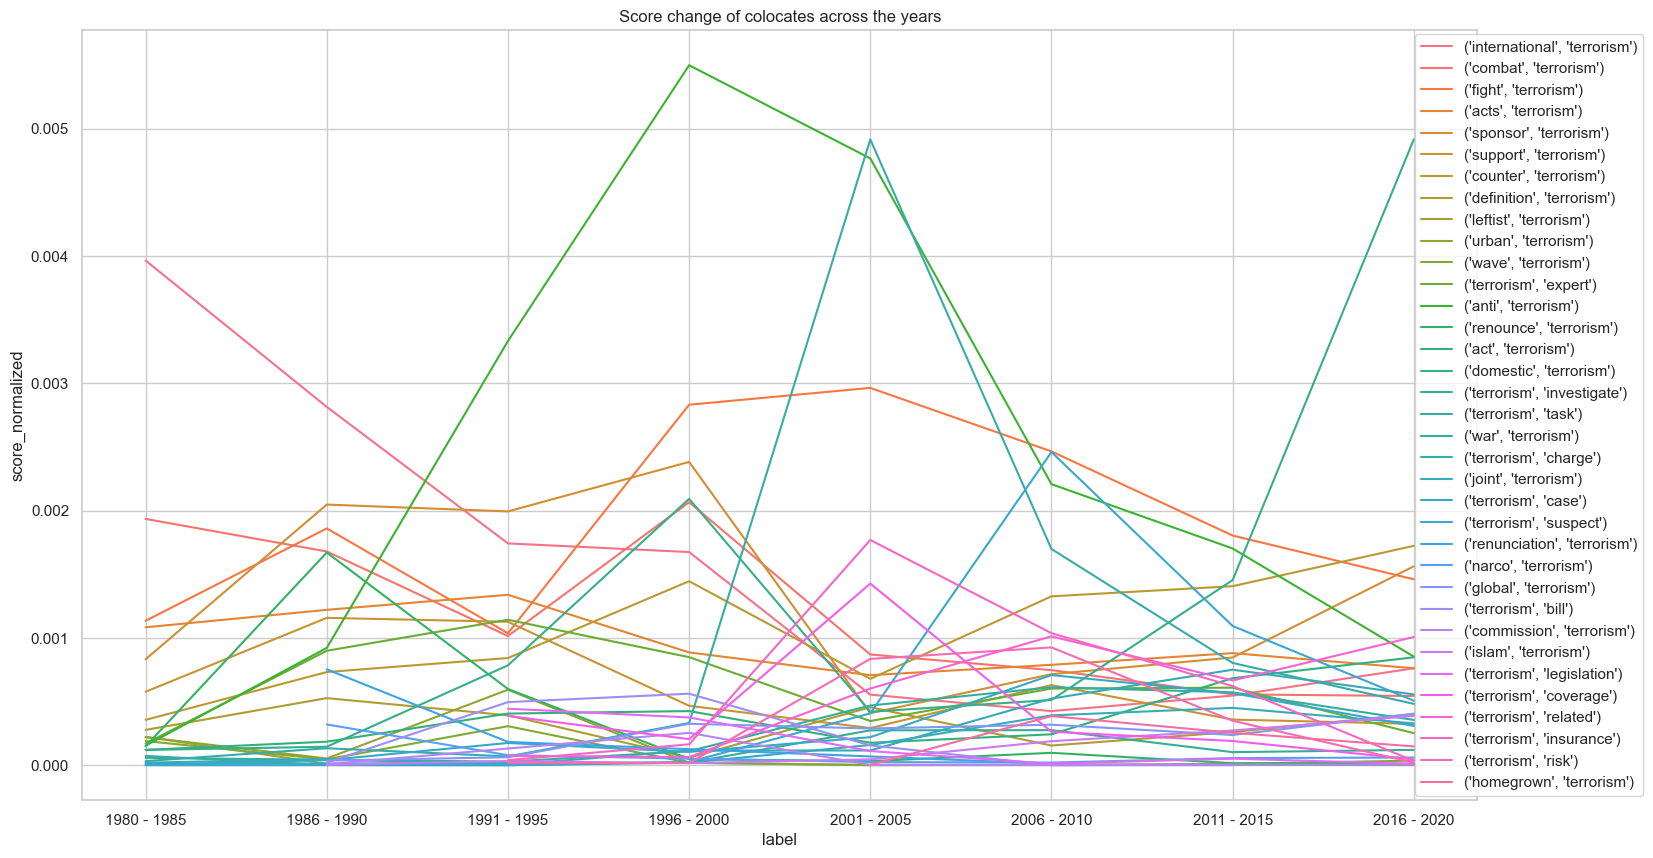

In [272]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_output_filtered = df_output.groupby('colocate').filter(lambda x:  np.std(x.score_normalized)  >= 0.0001)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 10))
sns.lineplot(data=df_output_filtered, x='label', y='score_normalized', hue='colocate')
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5), ncol=1)
plt.title('Score change of colocates across the years')
plt.savefig('output/colocates/colocates_by_years_stem.png')
plt.show()

In [280]:
df5 = df.loc[df['publisher'] == 'the new york times'] 
res5 = get_colocates(df5['cleaned_text_stem'], 'nyt')
res5


,rank,word_of_interest,colocate,score,score_normalized,label
0,0,terrorism,"(fight, terrorism)",4338.033372,1.816939e-03,nyt
1,1,terrorism,"(domestic, terrorism)",3961.431128,1.659203e-03,nyt
2,2,terrorism,"(terrorism, suspect)",3909.007102,1.637245e-03,nyt
3,3,terrorism,"(international, terrorism)",3709.904255,1.553853e-03,nyt
4,4,terrorism,"(sponsor, terrorism)",3127.973783,1.310118e-03,nyt
...,...,...,...,...,...,...
2557,2557,terrorism,"(terrorism, relative)",0.000008,3.456126e-12,nyt
2558,2558,terrorism,"(terrorism, strengthen)",0.000008,3.456126e-12,nyt
2559,2559,terrorism,"(terrorism, shortly)",0.000006,2.495072e-12,nyt
2560,2560,terrorism,"(terrorism, across)",0.000003,1.385178e-12,nyt


In [281]:
df6 = df.loc[df['publisher'] == 'pittsburgh post-gazette'] 
res6 = get_colocates(df6['cleaned_text_stem'], 'ppg')
res6

,rank,word_of_interest,colocate,score,score_normalized,label
0,0,terrorism,"(anti, terrorism)",1418.963000,4.605976e-03,ppg
1,1,terrorism,"(fight, terrorism)",731.313907,2.373856e-03,ppg
2,2,terrorism,"(counter, terrorism)",620.428711,2.013921e-03,ppg
3,3,terrorism,"(war, terrorism)",513.985013,1.668403e-03,ppg
4,4,terrorism,"(domestic, terrorism)",387.929551,1.259225e-03,ppg
...,...,...,...,...,...,...
476,476,terrorism,"(terrorism, organization)",0.002427,7.876500e-09,ppg
477,477,terrorism,"(charge, terrorism)",0.001928,6.259091e-09,ppg
478,478,terrorism,"(terrorism, washington)",0.000992,3.220282e-09,ppg
479,479,terrorism,"(terrorism, europe)",0.000658,2.135854e-09,ppg


In [282]:

df_output_by_media = pd.concat([res5, res6])
df_output_by_media.to_csv('output/colocates/colocates_by_media_stem.csv', index=False)


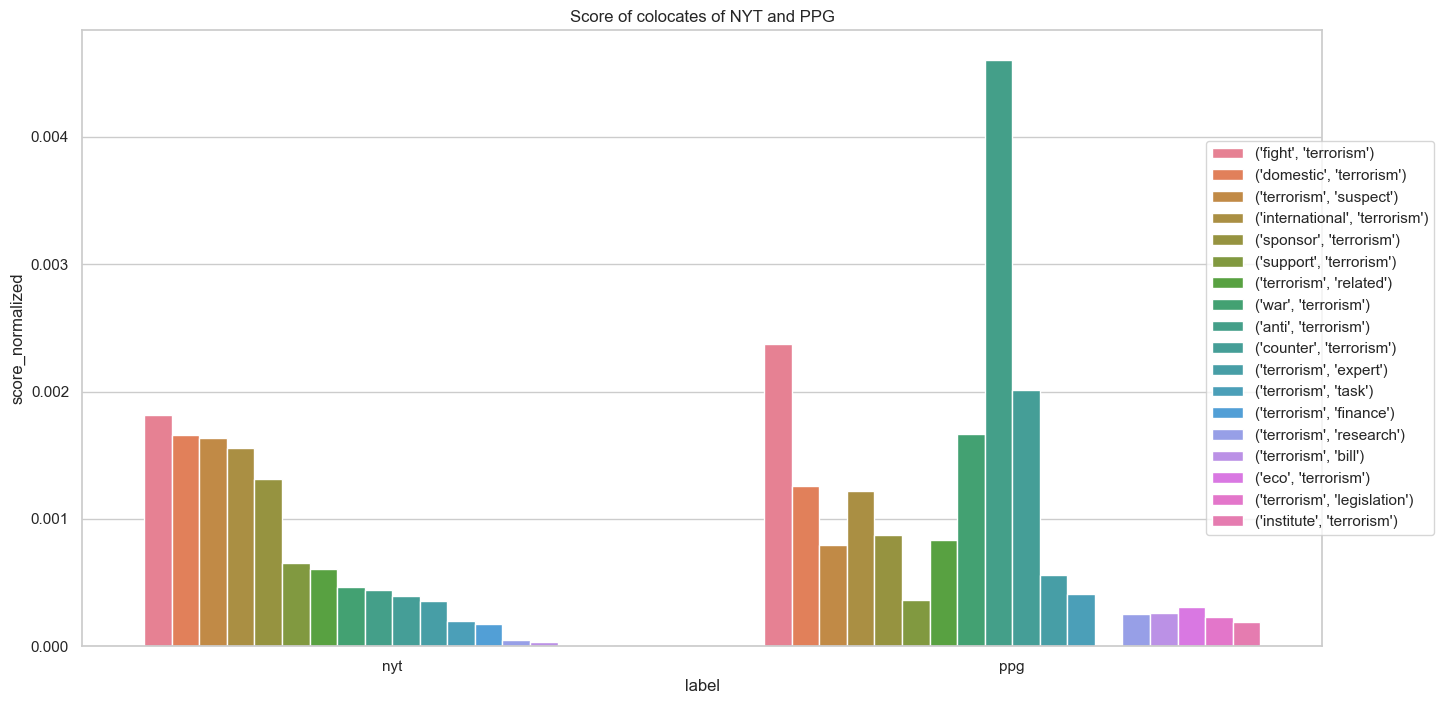

In [288]:
# filter out collates that appears in only one label
df_output_by_media_filtered = df_output_by_media.groupby('colocate').filter(lambda x:  np.std(x.score_normalized)  > 0.00008)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 8))
sns.barplot(data=df_output_by_media_filtered, x='label', y='score_normalized', hue='colocate')
# adjust the location of the legend
plt.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), ncol=1)
plt.title('Score of colocates of NYT and PPG')
plt.savefig('output/colocates/colocates_by_media_stem.png')
plt.show()

## Adjectives

In [149]:
# get the colocates for each date range
for date in date_range:
    df_date = df.loc[(df['year'] >= date[0]) & (df['year'] <= date[1])]
    res = get_colocates(df_date['cleaned_text_adj'], f'{date[0]} - {date[1]}')
    res.to_csv(f'output/colocates/colocates_adj_{date[0]}_{date[1]}.csv', index=False)
    
# combine the results
df_output = pd.concat([pd.read_csv(f'output/colocates/colocates_adj_{date[0]}_{date[1]}.csv') for date in date_range])
df_output.to_csv('output/colocates/colocates_adj_by_years_stem.csv', index=False)

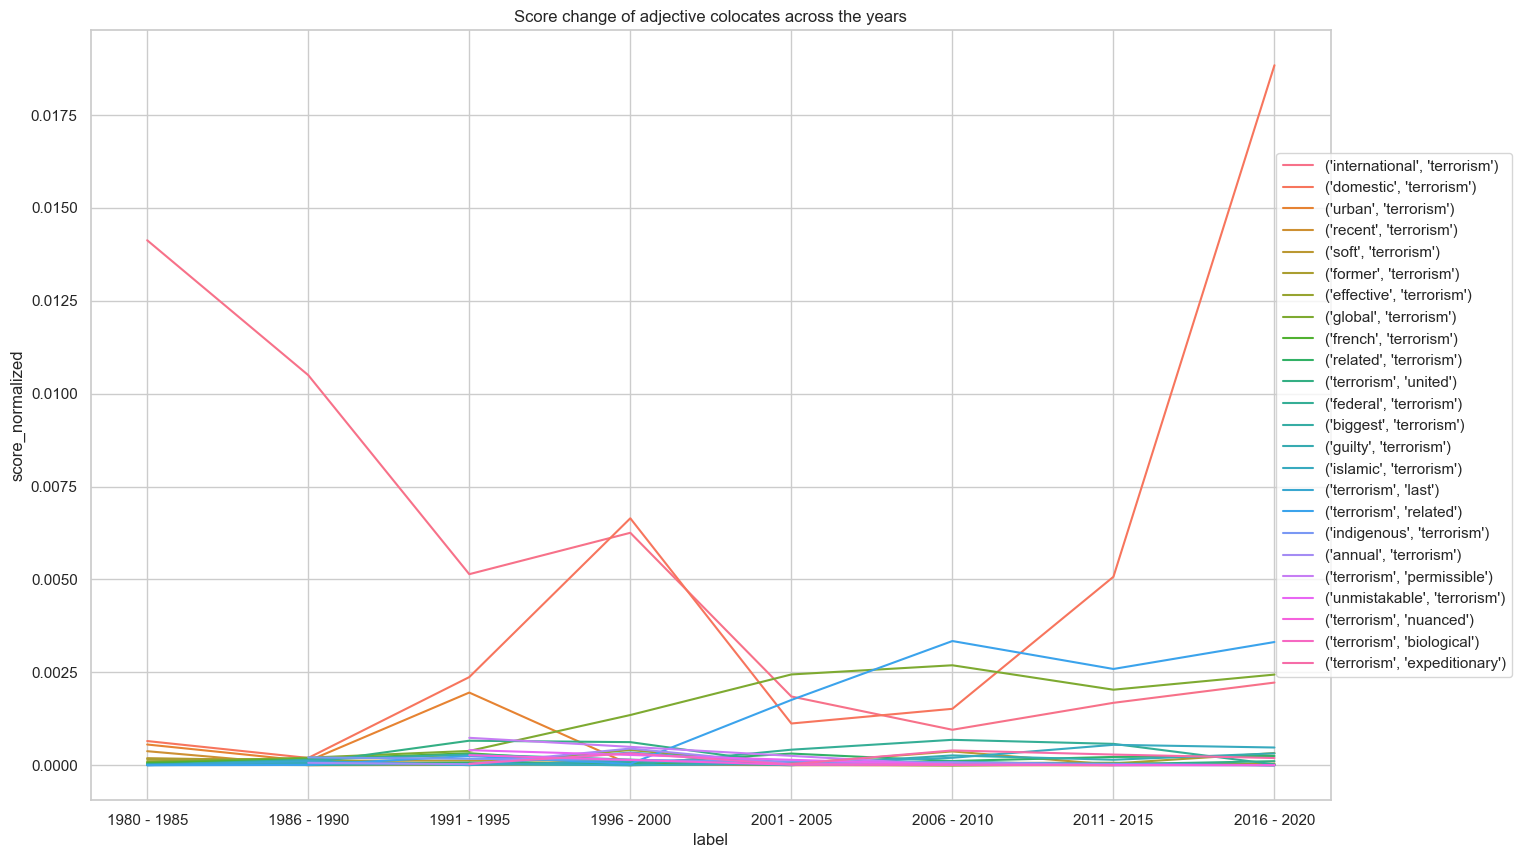

In [256]:
df_output_filtered = df_output.groupby('colocate').filter(lambda x:  np.std(x.score_normalized)  >= 0.0001)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 10))
sns.lineplot(data=df_output_filtered, x='label', y='score_normalized', hue='colocate')
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5), ncol=1)
plt.title('Score change of adjective colocates across the years')
plt.savefig('output/colocates/colocates_adj_by_years_stem.png')
plt.show()

In [260]:
df5 = df.loc[df['publisher'] == 'the new york times'] 
res5 = get_colocates(df5['cleaned_text_adj'], 'nyt')
res5

,rank,word_of_interest,colocate,score,score_normalized,label
0,0,terrorism,"(domestic, terrorism)",1600.374449,5.459755e-03,nyt
1,1,terrorism,"(international, terrorism)",1455.615056,4.965902e-03,nyt
2,2,terrorism,"(terrorism, related)",552.541241,1.885021e-03,nyt
3,3,terrorism,"(global, terrorism)",325.906814,1.111847e-03,nyt
4,4,terrorism,"(guilty, terrorism)",72.050550,2.458040e-04,nyt
...,...,...,...,...,...,...
1076,1076,terrorism,"(terrorism, flexible)",0.000097,3.316473e-10,nyt
1077,1077,terrorism,"(skeptical, terrorism)",0.000048,1.642238e-10,nyt
1078,1078,terrorism,"(national, terrorism)",0.000039,1.317887e-10,nyt
1079,1079,terrorism,"(terrorism, civil)",0.000003,1.036842e-11,nyt


In [261]:
df6 = df.loc[df['publisher'] == 'pittsburgh post-gazette'] 
res6 = get_colocates(df6['cleaned_text_adj'], 'ppg')
res6

,rank,word_of_interest,colocate,score,score_normalized,label
0,0,terrorism,"(international, terrorism)",1.713185e+02,4.704743e-03,ppg
1,1,terrorism,"(domestic, terrorism)",1.420626e+02,3.901318e-03,ppg
2,2,terrorism,"(terrorism, related)",1.125010e+02,3.089499e-03,ppg
3,3,terrorism,"(global, terrorism)",8.597239e+01,2.360971e-03,ppg
4,4,terrorism,"(controversial, terrorism)",1.388574e+01,3.813296e-04,ppg
...,...,...,...,...,...,...
417,417,terrorism,"(terrorism, constitutional)",6.593832e-05,1.810796e-09,ppg
418,418,terrorism,"(foreign, terrorism)",1.693796e-05,4.651496e-10,ppg
419,419,terrorism,"(terrorism, former)",1.693796e-05,4.651496e-10,ppg
420,420,terrorism,"(broad, terrorism)",6.550028e-07,1.798766e-11,ppg


In [262]:

df_output_by_media = pd.concat([res5, res6])
df_output_by_media.to_csv('output/colocates/colocates_adj_by_media_stem.csv', index=False)


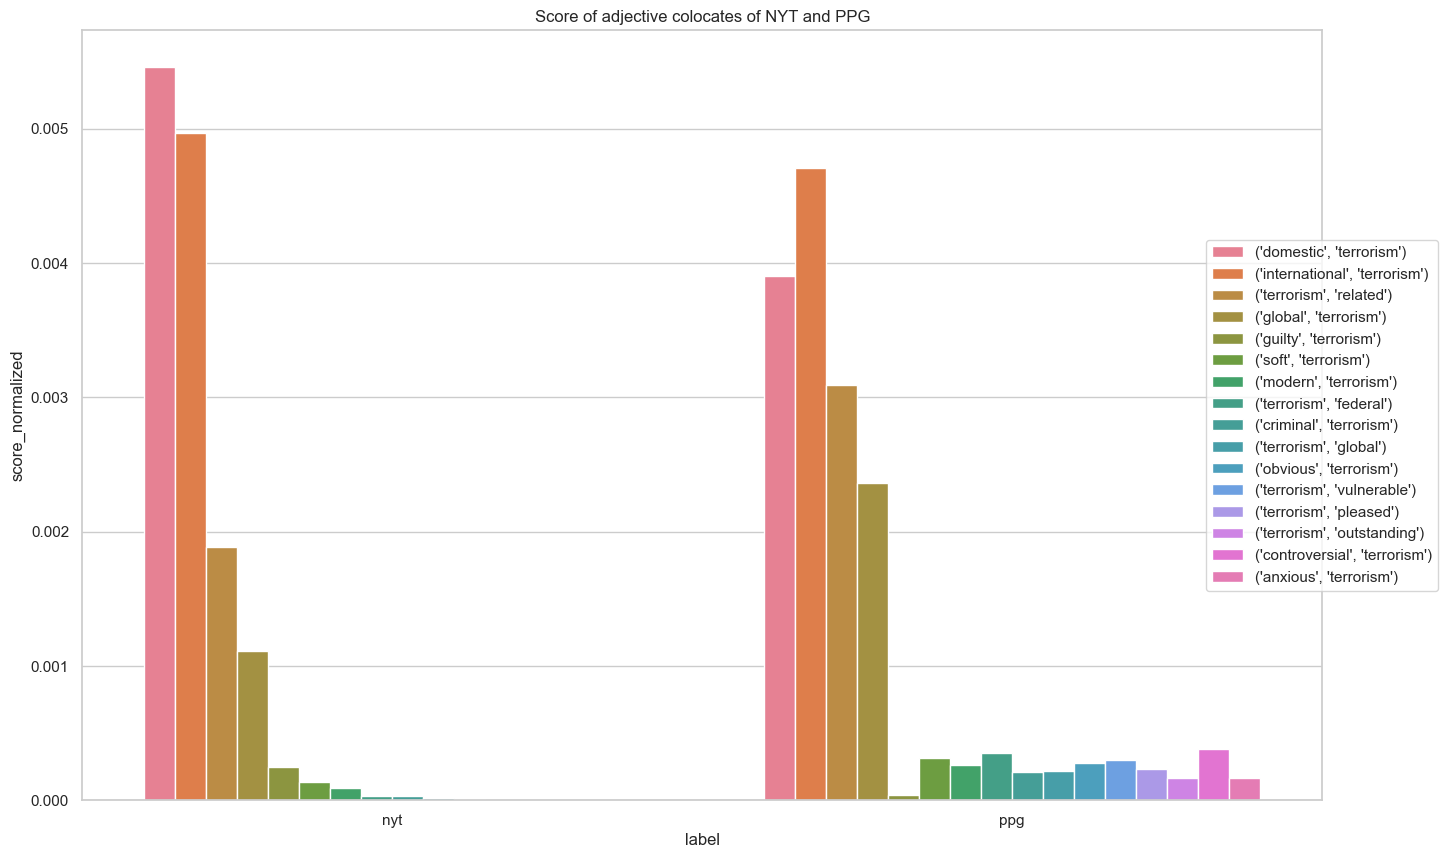

In [267]:
df_output_by_media_filtered = df_output_by_media.groupby('colocate').filter(lambda x:  np.std(x.score_normalized)  > 0.00008)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 10))
sns.barplot(data=df_output_by_media_filtered, x='label', y='score_normalized', hue='colocate')
# adjust the location of the legend
plt.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), ncol=1)
plt.title('Score of adjective colocates of NYT and PPG')
plt.savefig('output/colocates/colocates_adj_by_media_stem.png')
plt.show()

# Dynamic Topic Modeling by Years

In [169]:
from bertopic import BERTopic

def get_topics(df_news):
    news = df_news.loc[df_news['year'] >= 1980]['cleaned_text_stem'].tolist()
    topic_model = BERTopic(verbose=True)
    topics, probs = topic_model.fit_transform(news)
    dates = df_news.loc[df_news['year'] >= 1980]['year'].tolist()
    topics_over_time = topic_model.topics_over_time(news, dates, datetime_format='%Y', nr_bins=20)
    topics_per_class_groupby = topics_over_time.groupby('Timestamp').apply(lambda x: x['Frequency'] / x['Timestamp'].sum())
    topics_over_time['Frequency'] = topics_per_class_groupby.values
    return topic_model, topics_over_time


In [170]:
topic_model, topics_over_time = get_topics(df)
topic_model.get_topic_info().to_csv('output/dtm/topic_info.csv', index=False)
topic_model.get_topic_info()

2024-05-19 17:00:47,937 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/756 [00:00<?, ?it/s]

2024-05-19 17:02:35,127 - BERTopic - Embedding - Completed ✓
2024-05-19 17:02:35,131 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-19 17:02:39,972 - BERTopic - Dimensionality - Completed ✓
2024-05-19 17:02:39,973 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current p

,Topic,Count,Name,Representation,Representative_Docs
0,-1,8401,-1_america_terrorism_terrorist_said,"[america, terrorism, terrorist, said, people, ...",[extremist exploit western vulnerable civilize...
1,0,1066,0_israel_palestinian_arafat_peace,"[israel, palestinian, arafat, peace, hama, plo...",[britain abandoned palestine mandate may decis...
2,1,907,1_pakistan_india_indian_kashmir,"[pakistan, india, indian, kashmir, musharraf, ...",[terrorism top item first formal india pakista...
3,2,555,2_insurance_insurer_coverage_risk,"[insurance, insurer, coverage, risk, tria, bac...",[washington odds terrorism risk insurance act ...
4,3,344,3_iraq_bush_saddam_war,"[iraq, bush, saddam, war, hussein, america, pr...",[surprising president george w bush tuesday ti...
...,...,...,...,...,...
293,292,10,292_student_college_course_pvcc,"[student, college, course, pvcc, degree, progr...",[read time minute second rutger camden deprive...
294,293,10,293_laden_bin_strike_embassy,"[laden, bin, strike, embassy, lavey, missile, ...",[expert express conflict opinion yesterday whe...
295,294,10,294_airline_athan_loss_tourlite,"[airline, athan, loss, tourlite, twa, travel, ...",[airline industry could dealt disastrous blow ...
296,295,10,295_nsa_data_record_udall,"[nsa, data, record, udall, phone, verizon, pri...",[national security agency gathering record ver...


In [171]:
topics_over_time.to_csv('output/dtm/topics_over_time.csv', index=False)
topics_over_time


,Topic,Words,Frequency,Timestamp
0,-1,"soviet, reagan, guatemala, libya, subcommittee",0.001120,1979.96
1,0,"israel, palestinian, lebanon, arab, arafat",0.000463,1979.96
2,1,"naxalite, zia, pakistan, landless, nadu",0.000034,1979.96
3,3,"iraq, baghdad, hussein, azzawi, supplier",0.000017,1979.96
4,4,"france, mitterrand, paris, defferre, directe",0.000093,1979.96
...,...,...,...,...
2383,285,"jersey, kosher, anderson, grew, fulop",0.000028,2018.00
2384,287,"lawyer, doctor, cardiology, hospital, patient",0.000003,2018.00
2385,289,"homeland, department, mcaleenan, nielsen, antifa",0.000019,2018.00
2386,292,"communication, student, bachelor, gimbal, kuntz",0.000006,2018.00


In [179]:
topics_over_time_filtered = topics_over_time.groupby('Topic').filter(lambda x:  np.std(x.Frequency)  > 0.000048)
fig = topic_model.visualize_topics_over_time(topics_over_time_filtered)
# enlarge the size of the plot
fig.update_layout(width=1200, height=800)
fig.write_image('output/dtm/topics_over_time.png', engine="orca")
fig.show()

# Dynamic Topic Modeling by Media

In [187]:
def get_topics_by_classes(df_news):
    news = df_news['cleaned_text_stem'].tolist()
    topic_model = BERTopic(verbose=True)
    topics, probs = topic_model.fit_transform(news)
    classes = df_news['publisher'].tolist()
    topics_per_class = topic_model.topics_per_class(news, classes=classes)
    topics_per_class_media_groupby = topics_per_class.groupby('Class').apply(lambda x: x['Frequency'] / x['Frequency'].sum())
    topics_per_class['Frequency'] = topics_per_class_media_groupby.values
    return topic_model, topics_per_class

In [188]:
df_nyt = df.loc[df['publisher'] == 'the new york times'] 
df_ppg = df.loc[df['publisher'] == 'pittsburgh post-gazette'] 


In [189]:
# concat df_nyt and df_ppg
df_media = pd.concat([df_nyt, df_ppg])
topic_model_media, topics_per_class_media = get_topics_by_classes(df_media)
topic_model_media.get_topic_info()

2024-05-19 17:09:55,774 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/196 [00:00<?, ?it/s]

2024-05-19 17:10:24,020 - BERTopic - Embedding - Completed ✓
2024-05-19 17:10:24,021 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-19 17:10:27,025 - BERTopic - Dimensionality - Completed ✓
2024-05-19 17:10:27,026 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-19 17:10:27,113 - BERTopic - Cluster - Completed ✓
2024-05-19 17:10:27,114 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-05-19 17:10:28,848 - BERTopic - Representation - Completed ✓
2it [00:01,  1.96it/s]
/var/folders/dm/hs6ffqd576v39l4vtyx6rpg00000gn/T/ipykernel_12920/476898731.py:7: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,Topic,Count,Name,Representation,Representative_Docs
0,-1,1754,-1_mr_said_terrorism_america,"[mr, said, terrorism, america, terrorist, unit...",[western europe police intelligence politics o...
1,0,284,0_israel_palestinian_arafat_peace,"[israel, palestinian, arafat, peace, arab, jew...",[release yasir arafat dawn monthlong siege isr...
2,1,234,1_britain_london_police_attack,"[britain, london, police, attack, said, mr, ar...",[britain police conduct series raid wednesday ...
3,2,220,2_pakistan_india_indian_afghanistan,"[pakistan, india, indian, afghanistan, mumbai,...",[pakistan religious student protest president ...
4,3,210,3_france_paris_attack_macron,"[france, paris, attack, macron, police, europe...",[year old immigrant pakistan arrest friday sta...
...,...,...,...,...,...
93,92,11,92_bank_plaintiff_arab_hama,"[bank, plaintiff, arab, hama, account, transac...",[role bank forced operate area torn apart terr...
94,93,10,93_court_solicitor_amendment_law,"[court, solicitor, amendment, law, supreme, fi...",[washington last june supreme court ask trump ...
95,94,10,94_headley_pakistan_shahzad_rana,"[headley, pakistan, shahzad, rana, kashmiri, c...",[two chicago men charged official said plot at...
96,95,10,95_miller_trump_tank_think,"[miller, trump, tank, think, breitbart, white,...",[pretend teleprompter speech change anything d...


In [190]:
topics_per_class_media.to_csv('output/dtm/topics_per_media.csv', index=False)
topics_per_class_media

,Topic,Words,Frequency,Class
0,-1,"said, terrorism, terrorist, mr, america",0.305495,pittsburgh post-gazette
1,0,"israel, palestinian, arafat, peace, plo",0.046154,pittsburgh post-gazette
2,1,"britain, london, police, miranda, blair",0.020879,pittsburgh post-gazette
3,2,"pakistan, india, afghanistan, militant, indian",0.041758,pittsburgh post-gazette
4,3,"france, paris, carlos, belgium, attack",0.012088,pittsburgh post-gazette
...,...,...,...,...
182,92,"bank, plaintiff, arab, hama, account",0.002061,the new york times
183,93,"court, solicitor, fisa, law, supreme",0.001312,the new york times
184,94,"headley, pakistan, shahzad, rana, kashmiri",0.001874,the new york times
185,95,"miller, trump, tank, think, breitbart",0.001687,the new york times


     Topic                                              Words  Frequency  \
2        1            britain, london, police, miranda, blair   0.020879   
4        3             france, paris, carlos, belgium, attack   0.012088   
7        6                      fbi, police, city, bomb, nypd   0.039560   
8        7             libya, gadhafi, rice, algeria, morocco   0.004396   
9        8    guantanamo, detainee, trial, military, mohammed   0.007692   
10       9            turkey, ocalan, kurdish, istanbul, pera   0.004396   
11      10     aristide, haiti, honduras, nicaragua, salvador   0.005495   
12      11                 spain, madrid, basque, europe, eta   0.005495   
13      12             ireland, ira, northern, britain, adams   0.021978   
19      18                 syria, assad, raqqa, peace, israel   0.002198   
30      29                  bush, iraq, war, democracy, perle   0.017582   
34      33           bill, senate, provisions, wiretap, house   0.019780   
38      38  

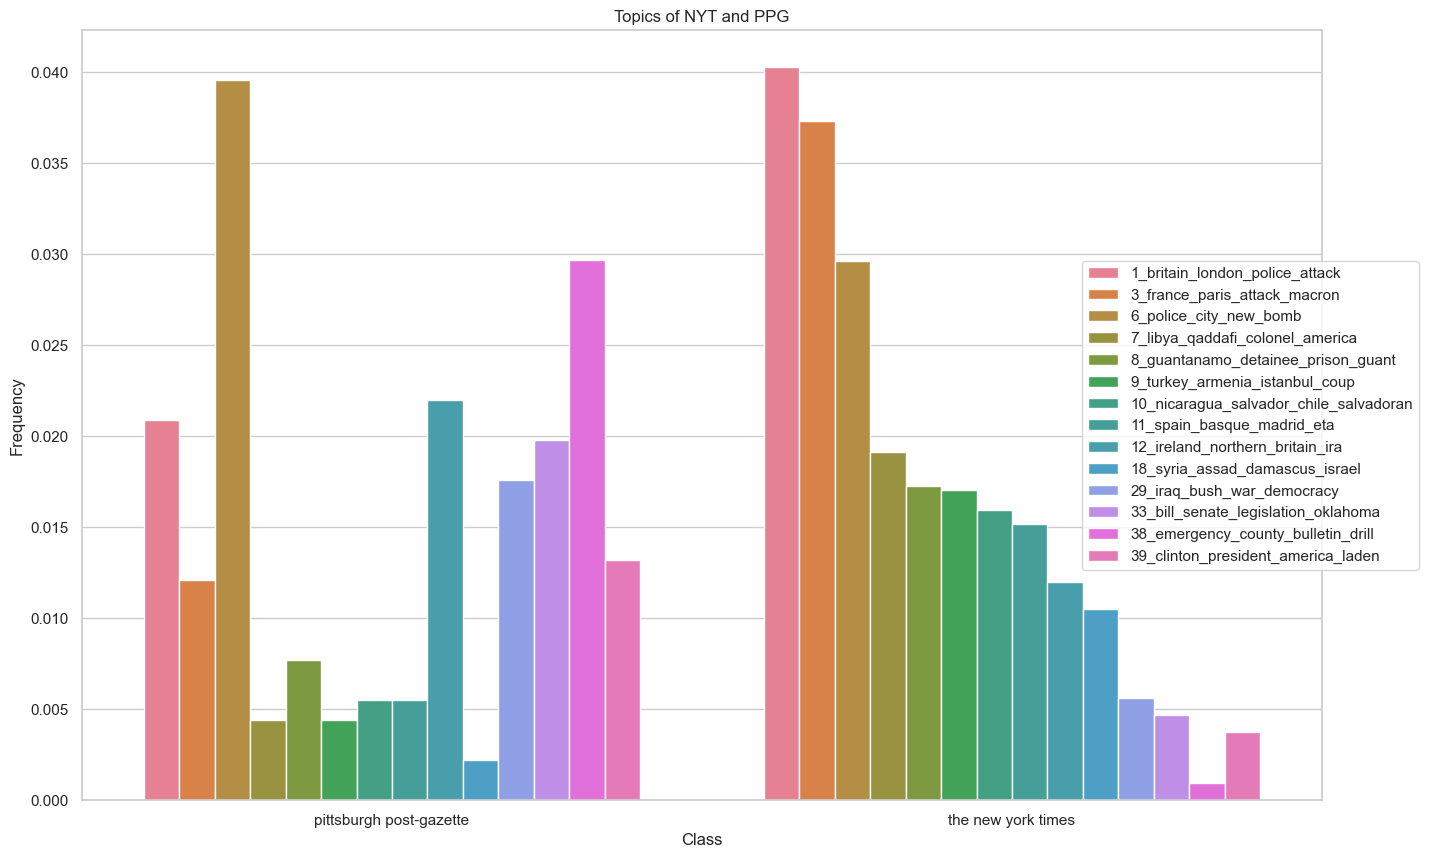

In [269]:
# topics_over_time_filtered = topics_over_time.groupby('Topic').filter(lambda x:  np.std(x.Frequency)  > 0.000048)
# fig = topic_model.visualize_topics_over_time(topics_over_time_filtered)
# # enlarge the size of the plot
# fig.update_layout(width=1200, height=800)
# fig.write_image('output/dtm/topics_over_time.png', engine="orca")
# fig.show()

topics_per_class_media_filtered = topics_per_class_media.groupby('Topic').filter(lambda x:  np.std(x.Frequency)  > 0.004)
# filter out Topic -1
topics_per_class_media_filtered = topics_per_class_media_filtered.loc[topics_per_class_media_filtered['Topic'] != -1]
print(topics_per_class_media_filtered)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 10))
sns.barplot(data=topics_per_class_media_filtered, x='Class', y='Frequency', hue='Name')
# adjust the location of the legend
plt.legend(loc='center left', bbox_to_anchor=(0.8, 0.5), ncol=1)
plt.title('Topics of NYT and PPG')
plt.savefig('output/dtm/topics_per_media.png')
plt.show()
